BANK CREDIT SCORING

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import pycaret
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve
from pycaret.classification import ClassificationExperiment
 



In [3]:
df = pd.read_csv('bank.csv', sep=";")
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


Data Dictionary:
1.age: Applicant's age
2.job: Employment status
3.marital: Marital status
4.education: education level
5.default: was previously default
6.balance: Total balance on applicant account
7.housing: whether applicant has a house
8.loan: loan amount applied for
9.contact: how to contact with loaner
10.day: how many days ago loaner borrowed from bank
11.month: month when loan has been taken
12.duration: loan duration
13.campaign: how many times person has taken a loan
14.pdays: none
15.previous: none
16.poutcome: none
17.y: Target


Exploratory Data Analysis: Explore the data to understand it better ie. Mean, mode, distributions
1. check for duplicates
2. check for nulls/ missing values
3. Imputing missing values
4. check for outliers through histogram, kde, boxplot and treat them.
5. Categorical data encodeing
6. Variable transformations.eg log transformations


In [4]:
df.info() # check for nulls and data types of variables

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4521 entries, 0 to 4520
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        4521 non-null   int64 
 1   job        4521 non-null   object
 2   marital    4521 non-null   object
 3   education  4521 non-null   object
 4   default    4521 non-null   object
 5   balance    4521 non-null   int64 
 6   housing    4521 non-null   object
 7   loan       4521 non-null   object
 8   contact    4521 non-null   object
 9   day        4521 non-null   int64 
 10  month      4521 non-null   object
 11  duration   4521 non-null   int64 
 12  campaign   4521 non-null   int64 
 13  pdays      4521 non-null   int64 
 14  previous   4521 non-null   int64 
 15  poutcome   4521 non-null   object
 16  y          4521 non-null   object
dtypes: int64(7), object(10)
memory usage: 600.6+ KB


In [5]:
# unique values for categorical variables

object_columns  = df.select_dtypes(include=['object']).columns
for column in object_columns:
    unique_values = df[column].unique()
    print(f'Unique vals for {column}: {unique_values}')

Unique vals for job: ['unemployed' 'services' 'management' 'blue-collar' 'self-employed'
 'technician' 'entrepreneur' 'admin.' 'student' 'housemaid' 'retired'
 'unknown']
Unique vals for marital: ['married' 'single' 'divorced']
Unique vals for education: ['primary' 'secondary' 'tertiary' 'unknown']
Unique vals for default: ['no' 'yes']
Unique vals for housing: ['no' 'yes']
Unique vals for loan: ['no' 'yes']
Unique vals for contact: ['cellular' 'unknown' 'telephone']
Unique vals for month: ['oct' 'may' 'apr' 'jun' 'feb' 'aug' 'jan' 'jul' 'nov' 'sep' 'mar' 'dec']
Unique vals for poutcome: ['unknown' 'failure' 'other' 'success']
Unique vals for y: ['no' 'yes']


[Text(0, 0, '4000'), Text(0, 0, '521')]

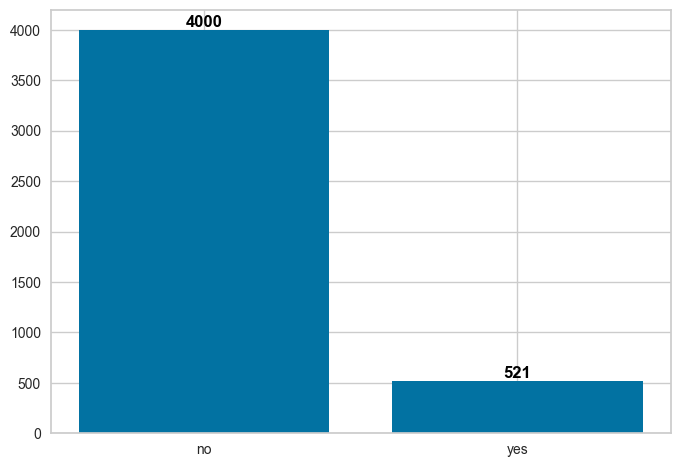

In [6]:
# class counts for target variable
y_counts = df['y'].value_counts()
labels = y_counts.index
sizes = y_counts.values
plots = plt.bar(labels, sizes, align='center')
plt.bar_label(plots,sizes, color='black', fontweight='bold')

In [7]:
categorical_df = []
for col in df.columns:
    if df[col].nunique()<10:
        categorical_df.append(col)

print('categ numericals columns are {}'.format(categorical_df))

categ numericals columns are ['marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome', 'y']


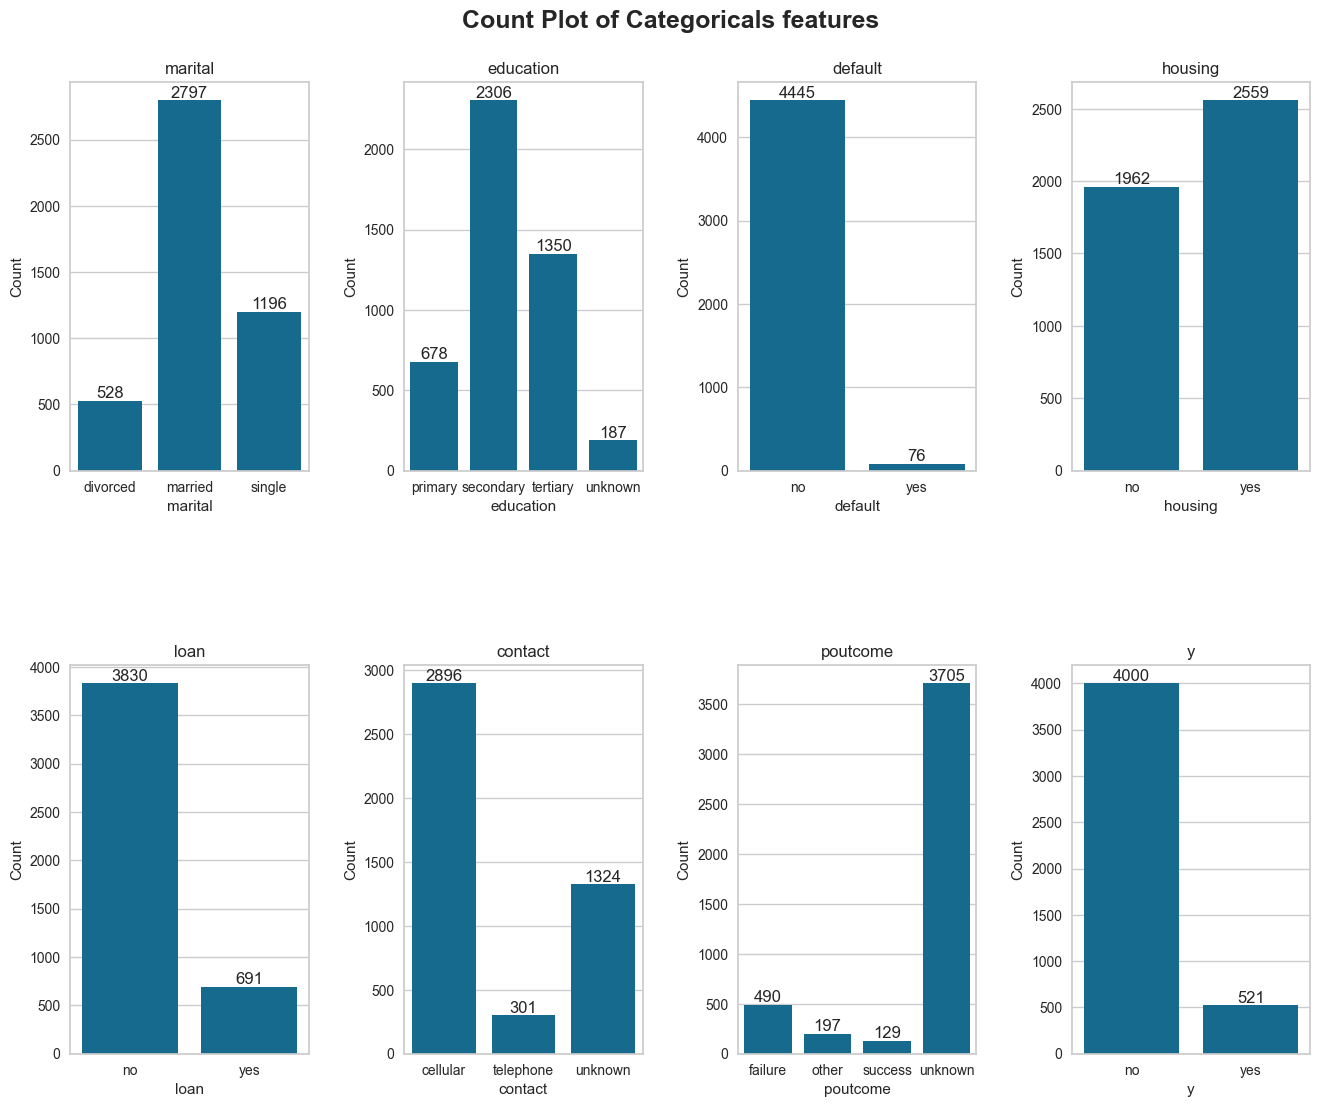

In [8]:
fig = plt.figure(figsize=[16,12])
fig.suptitle('Count Plot of Categoricals features', fontsize=18, fontweight='bold')
fig.subplots_adjust(top=0.92);
fig.subplots_adjust(hspace=0.5, wspace=0.4);
for i , columns in enumerate(categorical_df):
    input = np.unique(df[columns] , return_counts = True)
    col= 'input'
    ax1 = fig.add_subplot(2, 4, i+1);
    ax1 = sns.barplot(x=list(eval(f'{col}[0]')), y=list(eval(f'{col}[1]')))
    ax1.set_title(f'{columns}')
    ax1.set_xlabel(f'{columns}')
    ax1.set_ylabel('Count')
    ax1.bar_label(ax1.containers[0])

In [9]:
# Select only the numerical columns/variables
numerical_df = df.select_dtypes(include=['int64', 'float64'])
print(numerical_df.columns)

Index(['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous'], dtype='object')


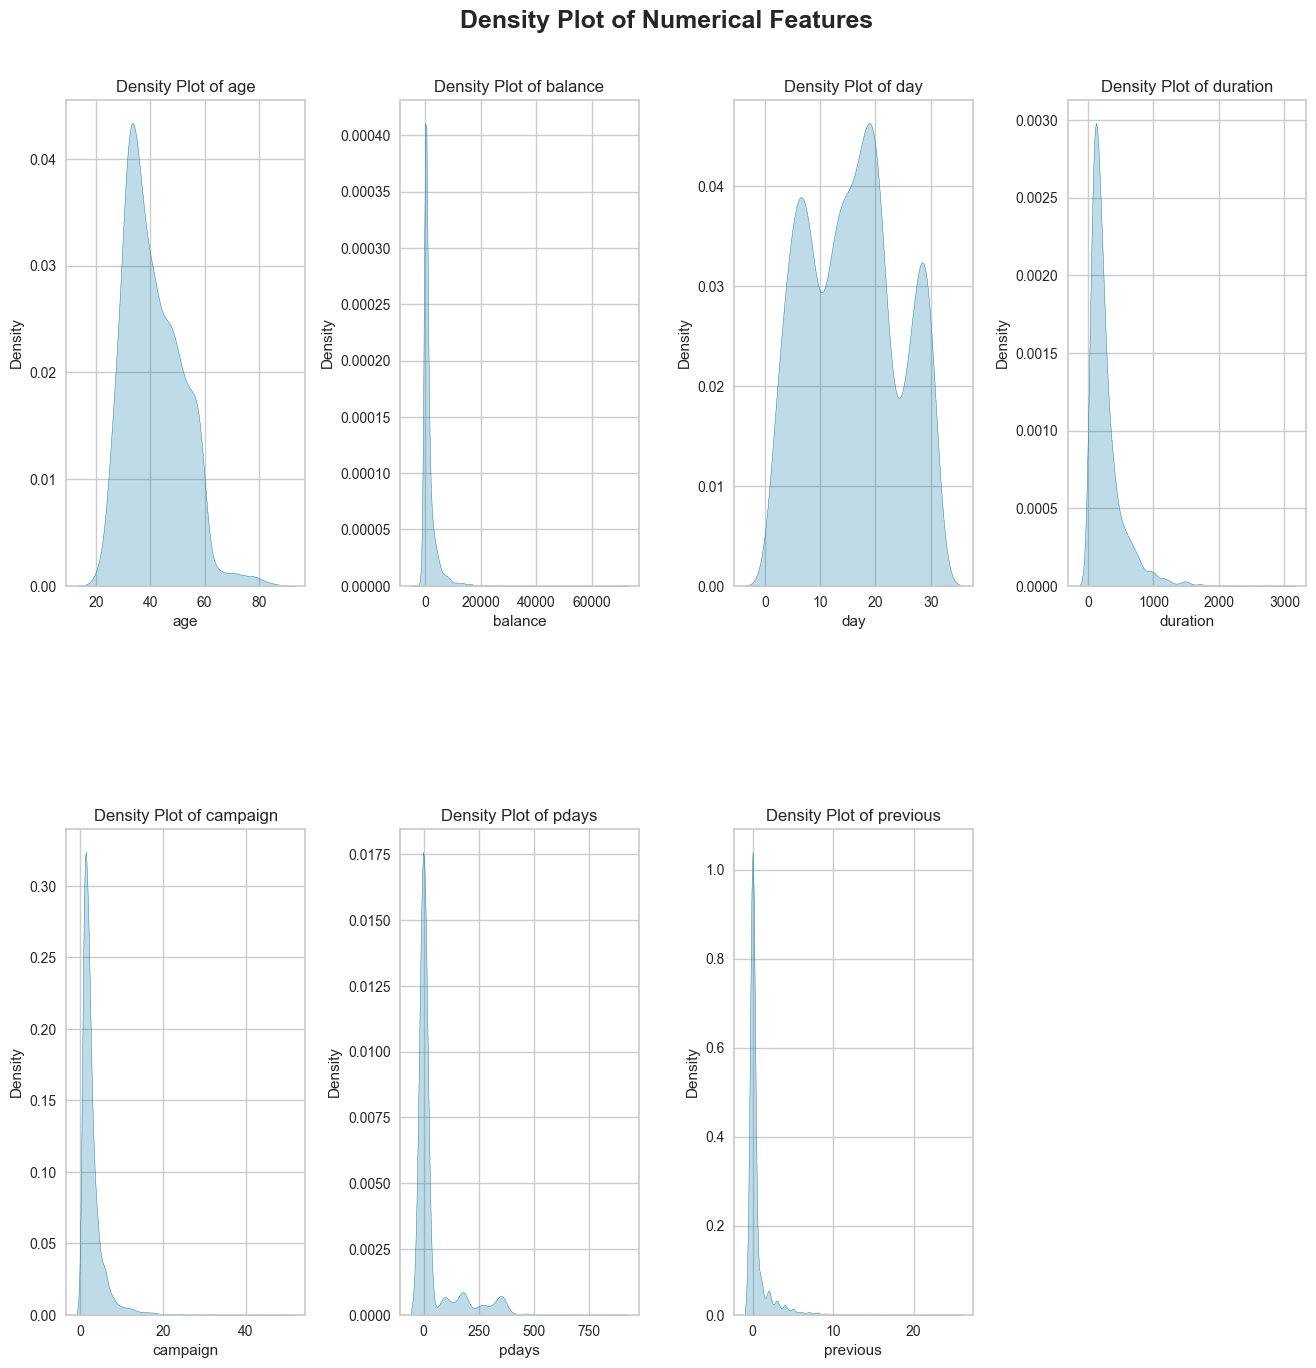

In [10]:
# Set the figure size and title
fig = plt.figure(figsize=(16, 15))
fig.suptitle('Density Plot of Numerical Features', fontsize=18, fontweight='bold')
fig.subplots_adjust(top=0.92)
fig.subplots_adjust(hspace=0.5, wspace=0.4)

# Loop through numerical columns and create density plots.These help look at distribution
for i, column in enumerate(numerical_df.columns):
    ax = fig.add_subplot(2, 4, i + 1)
    sns.kdeplot(data=numerical_df, x=column, fill=True, ax=ax)
    ax.set_title(f'Density Plot of {column}')
    ax.set_xlabel(column)
    ax.set_ylabel('Density')

plt.show()

Bivariate Analysis.
we look at how the categorical and numerical variables are related to loan approval 

In [11]:
categorical_df = df.select_dtypes(include=['object'])
categorical_df.drop(['y'], axis=1, inplace=True)

# Filter columns with less than 10 unique categories
categorical_cols_to_keep = []
for col in categorical_df.columns:
    if len(categorical_df[col].unique()) < 10:
        categorical_cols_to_keep.append(col)

# Select only the filtered columns
categorical_df = categorical_df[categorical_cols_to_keep]

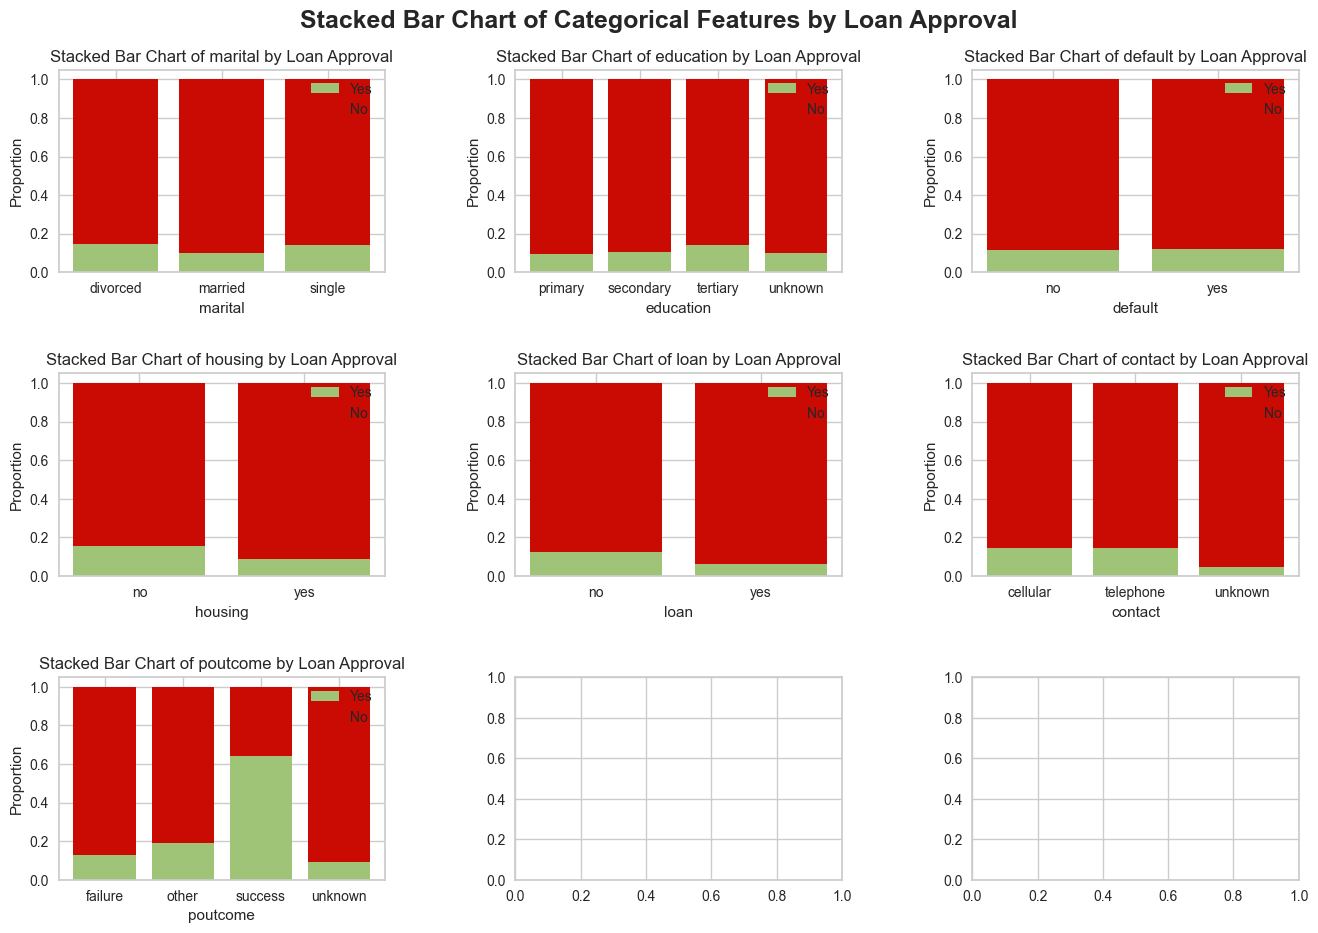

In [12]:
# Set the figure size and title
fig, axes = plt.subplots(3, 3, figsize=(16, 10))
fig.suptitle('Stacked Bar Chart of Categorical Features by Loan Approval', fontsize=18, fontweight='bold')
fig.subplots_adjust(top=0.92)
fig.subplots_adjust(hspace=0.5, wspace=0.4)

# Loop through categorical columns and create stacked bar charts based on 'y'
for i, column in enumerate(categorical_df.columns):
    ax = axes[i // 3, i % 3]

    # Create a cross-tabulation of the categorical column and 'y'
    crosstab = pd.crosstab(df[column], df['y'])

    # Calculate proportions
    proportions = crosstab.div(crosstab.sum(1), axis=0)

    # Create a stacked bar chart
    ax.bar(proportions.index, proportions['yes'], label='Yes', color='g')
    ax.bar(proportions.index, proportions['no'], label='No', bottom=proportions['yes'], color='r')

    ax.set_title(f'Stacked Bar Chart of {column} by Loan Approval')
    ax.set_xlabel(column)
    ax.set_ylabel('Proportion')
    ax.legend()

plt.show()

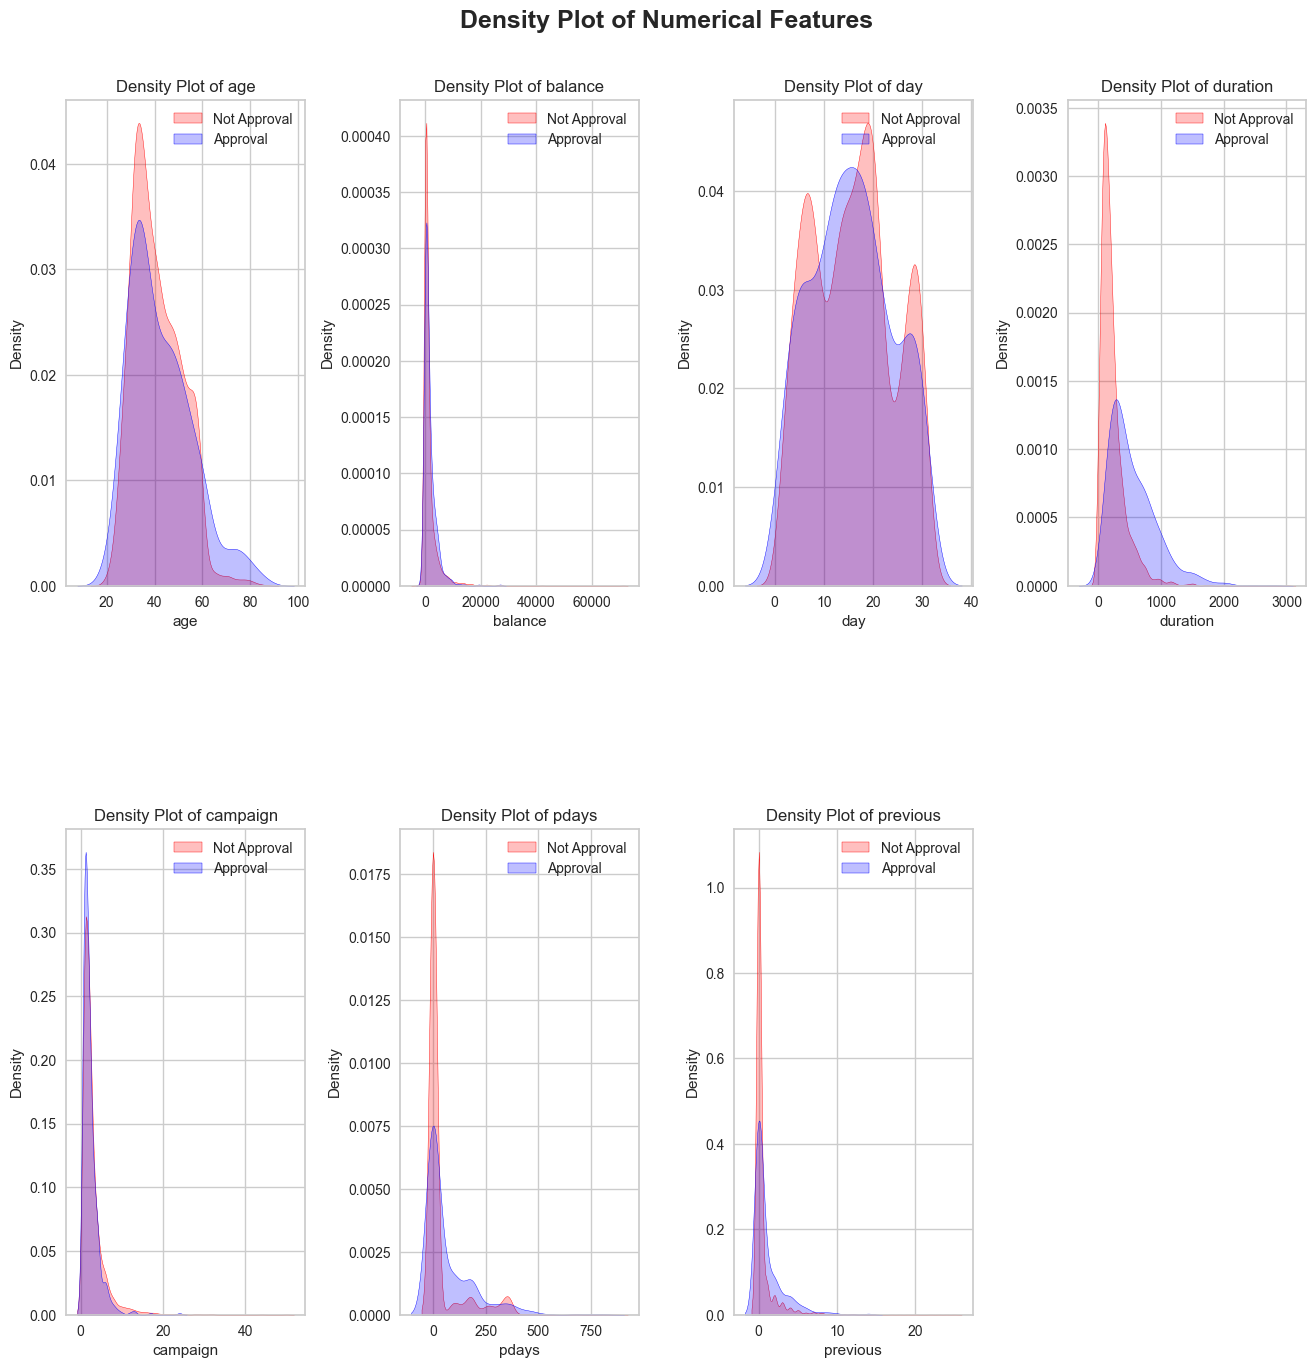

In [13]:
# Set the figure size and title
fig = plt.figure(figsize=(16, 15))
fig.suptitle('Density Plot of Numerical Features', fontsize=18, fontweight='bold')
fig.subplots_adjust(top=0.92)
fig.subplots_adjust(hspace=0.5, wspace=0.4)

# Loop through numerical columns and create density plots
for i, column in enumerate(numerical_df.columns):
    ax = fig.add_subplot(2, 4, i + 1)
    sns.kdeplot(data=df[df['y'] == 'no'][column], color="Red", fill=True, label="Not Approval")
    sns.kdeplot(data=df[df['y'] == 'yes'][column], color="Blue", fill=True, label="Approval")
    ax.set_title(f'Density Plot of {column}')
    ax.set_xlabel(column)
    ax.set_ylabel('Density')
    ax.legend()

plt.show()

Data Preprocessing:
1. encode categorical variables
2. fill unknowns with  NaN
3. Handle the missing values

In [14]:
# replace unknown values with NaN
df2  = df.replace('unknown', np.nan)


In [15]:
df2.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,NaN,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,NaN,3,jun,199,4,-1,0,NaN,no
4,59,blue-collar,married,secondary,no,0,yes,no,NaN,5,may,226,1,-1,0,NaN,no


In [16]:
df2.isnull().sum()

age             0
job            38
marital         0
education     187
default         0
balance         0
housing         0
loan            0
contact      1324
day             0
month           0
duration        0
campaign        0
pdays           0
previous        0
poutcome     3705
y               0
dtype: int64

In [17]:
df2.drop(['poutcome', 'contact'], axis=1, inplace=True)

In [18]:
# Encoding categorical variables
def object_to_int(dataframe_obj):
    if dataframe_obj.dtype=='object':
        dataframe_obj = LabelEncoder().fit_transform(dataframe_obj)
    return dataframe_obj

In [19]:
cpy_df = df2.copy(deep=True)
cpy_df = cpy_df.apply(lambda x: object_to_int(x))
cpy_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4521 entries, 0 to 4520
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   age        4521 non-null   int64
 1   job        4521 non-null   int32
 2   marital    4521 non-null   int32
 3   education  4521 non-null   int32
 4   default    4521 non-null   int32
 5   balance    4521 non-null   int64
 6   housing    4521 non-null   int32
 7   loan       4521 non-null   int32
 8   day        4521 non-null   int64
 9   month      4521 non-null   int32
 10  duration   4521 non-null   int64
 11  campaign   4521 non-null   int64
 12  pdays      4521 non-null   int64
 13  previous   4521 non-null   int64
 14  y          4521 non-null   int32
dtypes: int32(8), int64(7)
memory usage: 388.6 KB


In [20]:
cpy_df.dropna()

,age,job,marital,education,default,balance,housing,loan,day,month,duration,campaign,pdays,previous,y
0,30,10,1,0,0,1787,0,0,19,10,79,1,-1,0,0
1,33,7,1,1,0,4789,1,1,11,8,220,1,339,4,0
2,35,4,2,2,0,1350,1,0,16,0,185,1,330,1,0
3,30,4,1,2,0,1476,1,1,3,6,199,4,-1,0,0
4,59,1,1,1,0,0,1,0,5,8,226,1,-1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4516,33,7,1,1,0,-333,1,0,30,5,329,5,-1,0,0
4517,57,6,1,2,1,-3313,1,1,9,8,153,1,-1,0,0
4518,57,9,1,1,0,295,0,0,19,1,151,11,-1,0,0
4519,28,1,1,1,0,1137,0,0,6,3,129,4,211,3,0


Handling Outliers: mostly in the numerical variables
1. Interquartile range
2. Boxplot
3. Histogram

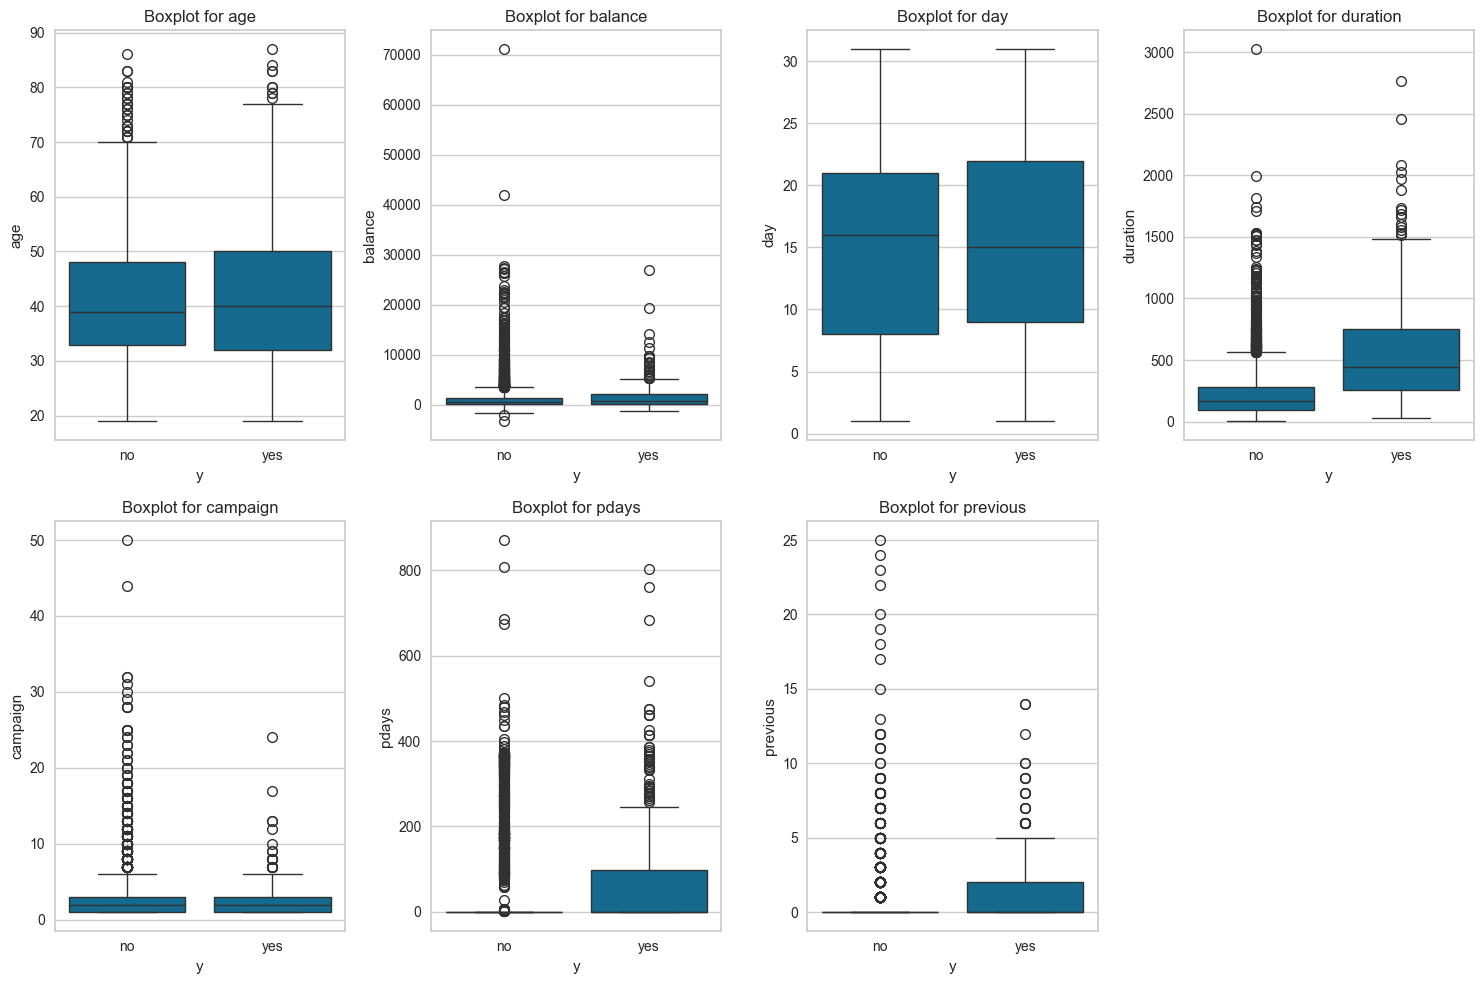

In [21]:
numerical_columns = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15, 10))

# Flatten the axes array to iterate through it easily
axes = axes.flatten()

# Loop through the numerical columns and create boxplots
for i, col in enumerate(numerical_columns):
    sns.boxplot(x='y', y=col, data=df, ax=axes[i])
    axes[i].set_title(f'Boxplot for {col}')

# Remove empty subplots if there are any
for i in range(len(numerical_columns), 2 * 4):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

In [22]:
def remove_outliers_iqr(data, numeric_columns, threshold=1.5):
    Q1 = data[numeric_columns].quantile(0.10)
    Q3 = data[numeric_columns].quantile(0.90)
    IQR = Q3 - Q1

    # Find rows containing outliers
    outlier_rows = ((data[numeric_columns] < (Q1 - threshold * IQR)) | (data[numeric_columns] > (Q3 + threshold * IQR))).any(axis=1)

    # Remove rows with outliers
    cleaned_data = data[~outlier_rows]

    return cleaned_data

In [23]:
cleaned_dataset = remove_outliers_iqr(cpy_df, numerical_columns)
df3 = pd.DataFrame(cleaned_dataset)

In [24]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4209 entries, 0 to 4519
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   age        4209 non-null   int64
 1   job        4209 non-null   int32
 2   marital    4209 non-null   int32
 3   education  4209 non-null   int32
 4   default    4209 non-null   int32
 5   balance    4209 non-null   int64
 6   housing    4209 non-null   int32
 7   loan       4209 non-null   int32
 8   day        4209 non-null   int64
 9   month      4209 non-null   int32
 10  duration   4209 non-null   int64
 11  campaign   4209 non-null   int64
 12  pdays      4209 non-null   int64
 13  previous   4209 non-null   int64
 14  y          4209 non-null   int32
dtypes: int32(8), int64(7)
memory usage: 394.6 KB


Robust scaling vs standard scaling.
Extreme values (outliers) can overshadow other data points for a given feature. That can negatively influence standard scaling, but
robust scaling works well on features with outliers.
Standard scaling uses mean and standard deviation. Robust scaling uses median and interquartile range (IQR) instead.
Robust scaling answers a simple question. How far is each data point from the input’s median? More precisely, it measures this distance in terms of the IQR using the below formula: 
ScaledValue= originalval - inputmedian/ inputIQR
The scaled values will have their median and IQR set to 0 and 1, respectively. The fact that robust scaling uses median and IQR makes it resistant to outliers.

In [39]:
# normalize the data
scaler = RobustScaler()
df_1 = df3[numerical_columns]
df_2 = df3.drop(numerical_columns,axis=1)
robust_df = scaler.fit_transform(df_1)
robust_df = pd.DataFrame(robust_df, columns=numerical_columns)
df_2 = pd.DataFrame(df_2)
robust_df.reset_index(drop=True, inplace=True)
df_2.reset_index(drop=True, inplace=True)
df_merges = pd.concat([robust_df, df_2], axis=1)
df_merges.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4209 entries, 0 to 4208
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        4209 non-null   float64
 1   balance    4209 non-null   float64
 2   day        4209 non-null   float64
 3   duration   4209 non-null   float64
 4   campaign   4209 non-null   float64
 5   pdays      4209 non-null   float64
 6   previous   4209 non-null   float64
 7   job        4209 non-null   int32  
 8   marital    4209 non-null   int32  
 9   education  4209 non-null   int32  
 10  default    4209 non-null   int32  
 11  housing    4209 non-null   int32  
 12  loan       4209 non-null   int32  
 13  month      4209 non-null   int32  
 14  y          4209 non-null   int32  
dtypes: float64(7), int32(8)
memory usage: 361.8 KB


In [40]:
df_merges.head()

,age,balance,day,duration,campaign,pdays,previous,job,marital,education,default,housing,loan,month,y
0,-0.5625,1.068858,0.250000,-0.479638,-0.5,0.0,0.0,10,1,0,0,0,0,10,0
1,-0.3750,3.417840,-0.416667,0.158371,-0.5,340.0,4.0,7,1,1,0,1,1,8,0
2,-0.2500,0.726917,0.000000,0.000000,-0.5,331.0,1.0,4,2,2,0,1,0,0,0
3,-0.5625,0.825509,-1.083333,0.063348,1.0,0.0,0.0,4,1,2,0,1,1,6,0
4,1.2500,-0.329421,-0.916667,0.185520,-0.5,0.0,0.0,1,1,1,0,1,0,8,0


<AxesSubplot: >

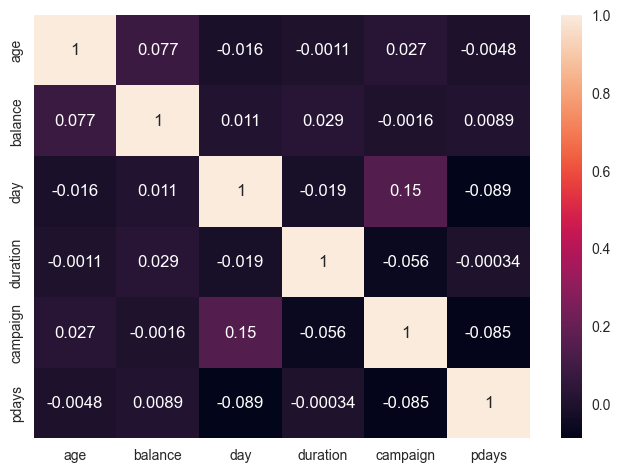

In [41]:
# Look for autocorrelated features. There's no correlation btn any features
df_num = df_merges[['age', 'balance', 'day', 'duration', 'campaign', 'pdays']]
sns.heatmap(df_num.corr(),annot=True)

In [42]:
# onehot encoding the data

one_hot_encoded_data = pd.get_dummies(df_merges, columns = ['education','marital','month','job'])
one_hot_encoded_data.head()

,age,balance,day,duration,campaign,pdays,previous,default,housing,loan,...,job_2,job_3,job_4,job_5,job_6,job_7,job_8,job_9,job_10,job_11
0,-0.5625,1.068858,0.250000,-0.479638,-0.5,0.0,0.0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,-0.3750,3.417840,-0.416667,0.158371,-0.5,340.0,4.0,0,1,1,...,0,0,0,0,0,1,0,0,0,0
2,-0.2500,0.726917,0.000000,0.000000,-0.5,331.0,1.0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
3,-0.5625,0.825509,-1.083333,0.063348,1.0,0.0,0.0,0,1,1,...,0,0,1,0,0,0,0,0,0,0
4,1.2500,-0.329421,-0.916667,0.185520,-0.5,0.0,0.0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


BUILDING THE MODEL

In [43]:
X= one_hot_encoded_data.drop('y',axis=1)
y= one_hot_encoded_data['y']

In [44]:
# Check the shape of X_resampled
num_rows_X, num_columns_X = X.shape
print(f'X: Number of rows = {num_rows_X}, Number of columns = {num_columns_X}')

# Check the shape of y_resampled
num_rows_y = y.shape[0]
print(f'y: Number of rows = {num_rows_y}')

X: Number of rows = 4209, Number of columns = 41
y: Number of rows = 4209


In [45]:
X_train, X_test,y_train, y_test = train_test_split(X,y,random_state=104,test_size=0.25, shuffle=True)

In [46]:
Random_sampler = RandomOverSampler()
X_resampled, y_resampled = Random_sampler.fit_resample(X, y)

In [47]:
X_train_smote, X_test_smote,y_train_smote, y_test_smote = train_test_split(X_resampled, y_resampled, random_state=42,test_size=0.25,shuffle=True)

MODEL SELECTION BY PYCARET

In [48]:
s = ClassificationExperiment()
s.setup(data=one_hot_encoded_data, target="y", session_id=1066)
s.compare_models(n_select = 5, sort='Accuracy', fold=5)

,Description,Value
0,Session id,1066
1,Target,y
2,Target type,Binary
3,Original data shape,"(4209, 42)"
4,Transformed data shape,"(4209, 42)"
5,Transformed train set shape,"(2946, 42)"
6,Transformed test set shape,"(1263, 42)"
7,Numeric features,41
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lda,Linear Discriminant Analysis,0.8995,0.8831,0.4191,0.5523,0.4762,0.4219,0.4270,0.0080
lr,Logistic Regression,0.8985,0.8802,0.2607,0.5788,0.3592,0.3127,0.3423,0.0380
et,Extra Trees Classifier,0.8975,0.8676,0.1893,0.6093,0.2877,0.2482,0.2990,0.0480
lightgbm,Light Gradient Boosting Machine,0.8975,0.8939,0.3197,0.5605,0.4047,0.3533,0.3713,0.0660
ada,Ada Boost Classifier,0.8958,0.8608,0.3075,0.5571,0.3909,0.3393,0.3598,0.0360
gbc,Gradient Boosting Classifier,0.8955,0.8890,0.2607,0.5467,0.3507,0.3020,0.3275,0.0800
ridge,Ridge Classifier,0.8951,0.0000,0.1645,0.5758,0.2544,0.2163,0.2670,0.0100
knn,K Neighbors Classifier,0.8931,0.7694,0.2361,0.5245,0.3251,0.2761,0.3024,0.0420
rf,Random Forest Classifier,0.8927,0.8946,0.1397,0.5428,0.2218,0.1849,0.2356,0.0560
dummy,Dummy Classifier,0.8907,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0060


[LinearDiscriminantAnalysis(covariance_estimator=None, n_components=None,
                            priors=None, shrinkage=None, solver='svd',
                            store_covariance=False, tol=0.0001),
 LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=1000,
                    multi_class='auto', n_jobs=None, penalty='l2',
                    random_state=1066, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False),
 ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                      criterion='gini', max_depth=None, max_features='sqrt',
                      max_leaf_nodes=None, max_samples=None,
                      min_impurity_decrease=0.0, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=1

In [49]:
# Linear discriminant model

ldr = LinearDiscriminantAnalysis(covariance_estimator=None, n_components=None,
                            priors=None, shrinkage=None, solver='svd',
                            store_covariance=False, tol=0.0001)

In [50]:
ldr.fit(X_train, y_train)
# Make predictions
predictions = ldr.predict(X_test)
print (accuracy_score(y_test, predictions))

0.9002849002849003


In [51]:
print(confusion_matrix(y_test, predictions))

[[898  47]
 [ 58  50]]


In [52]:
tp, fp, fn, tn = confusion_matrix(y_test, predictions).ravel()
print(tp, fp, fn, tn)

898 47 58 50


In [53]:
# model evaluation
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.94      0.95      0.94       945
           1       0.52      0.46      0.49       108

    accuracy                           0.90      1053
   macro avg       0.73      0.71      0.72      1053
weighted avg       0.90      0.90      0.90      1053



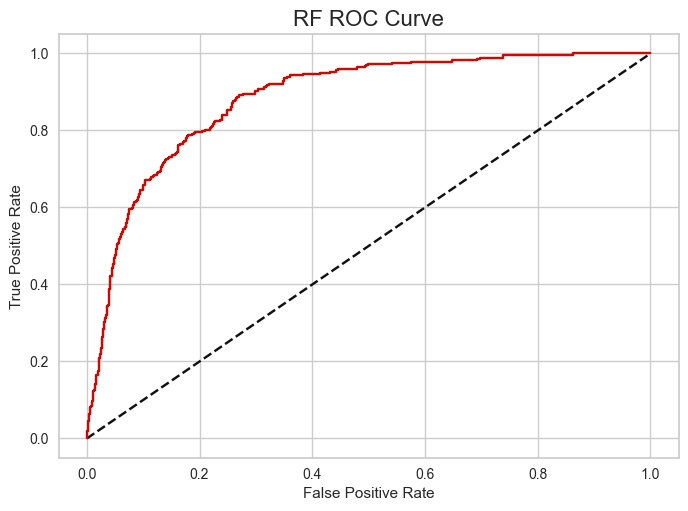

In [54]:
# ROC curve

y_rfpred_prob = ldr.predict_proba(X_test_smote)[:,1]
fpr_rf, tpr_rf, thresholds = roc_curve(y_test_smote, y_rfpred_prob)
plt.plot([0, 1], [0, 1], 'k--' )
plt.plot(fpr_rf, tpr_rf, label='Random Forest',color = "r")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('RF ROC Curve',fontsize=16)
plt.show();

In [67]:
# Get feature importance
result =  permutation_importance(ldr, X, y, n_repeats=10, random_state=0)
importances_list =  result.importances_mean.ravel()
print(sorted(importances_list))

 
 

[-0.0012354478498456055, -0.0009265858873842347, -0.0006177239249228305, -0.0004989308624376854, -0.00035637918745551334, -0.00035637918745548005, -0.00026134473746737276, -0.00023758612497035703, -0.00023758612497034592, -0.0002138275124733191, -0.000213827512473308, -0.000213827512473308, -0.00016631028747927657, -0.00016631028747925435, -0.00016631028747924326, -0.00014255167498222754, -9.503444998815169e-05, -7.127583749112487e-05, -7.127583749112487e-05, 0.0, 2.3758612496993515e-05, 2.3758612497004618e-05, 0.000118793062485123, 0.00019006889997620348, 0.0002613447374672839, 0.000261344737467295, 0.00026134473746731724, 0.00028510334996432183, 0.0003563791874554023, 0.00038013779995245135, 0.00040389641244948927, 0.00047517224994055864, 0.000760275599904936, 0.0007840342124019517, 0.0009503444998811728, 0.0009741031123781773, 0.0014730339748158182, 0.0042527916369683675, 0.008339272986457558, 0.010881444523639794, 0.050867189356141575]
